**Annotations to be added.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import  Counter

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

import os

In [2]:
torch.cuda.is_available()

True

In [3]:
data = pd.read_csv('train.csv')
data.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
len(data), any(data['image'].duplicated())

(6252, False)

In [5]:
data.category.unique()

array([1, 2, 3, 4, 5])

In [4]:
test_df = pd.read_csv('test_ApKoW4T.csv')
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [16]:
len(test_df), any(test_df['image'].duplicated())

(2680, False)

In [10]:
for img_name in test_df.image:
    img_path = os.path.join('images', img_name)
    move_path = os.path.join('test', img_name)
    shutil.move(img_path, move_path)

In [17]:
total_train_img = !ls images
len(total_train_img)

6252

In [9]:
total_test_img = !ls test
len(total_test_img)

2680

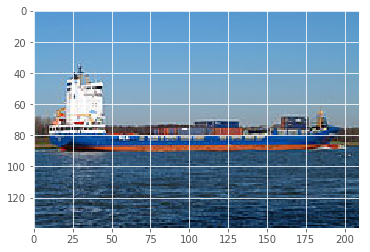

(140, 210, 3)

In [26]:
sample_img = plt.imread('images/2823080.jpg')
plt.imshow(sample_img)
plt.show()
sample_img.shape

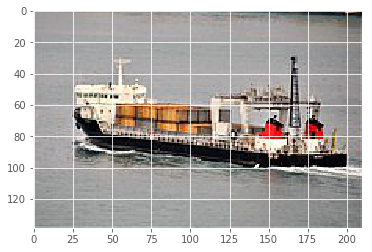

(139, 210, 3)

In [27]:
sample_img2 = plt.imread('images/2870024.jpg')
plt.imshow(sample_img2)
plt.show()
sample_img2.shape

In [8]:
# Batches of 64
databunch = ImageDataBunch.from_csv(Path('images'), ds_tfms=get_transforms(),
                                  csv_labels='train.csv',
                                  valid_pct=0.15,
                                size=(140,210), bs=64).normalize(imagenet_stats)

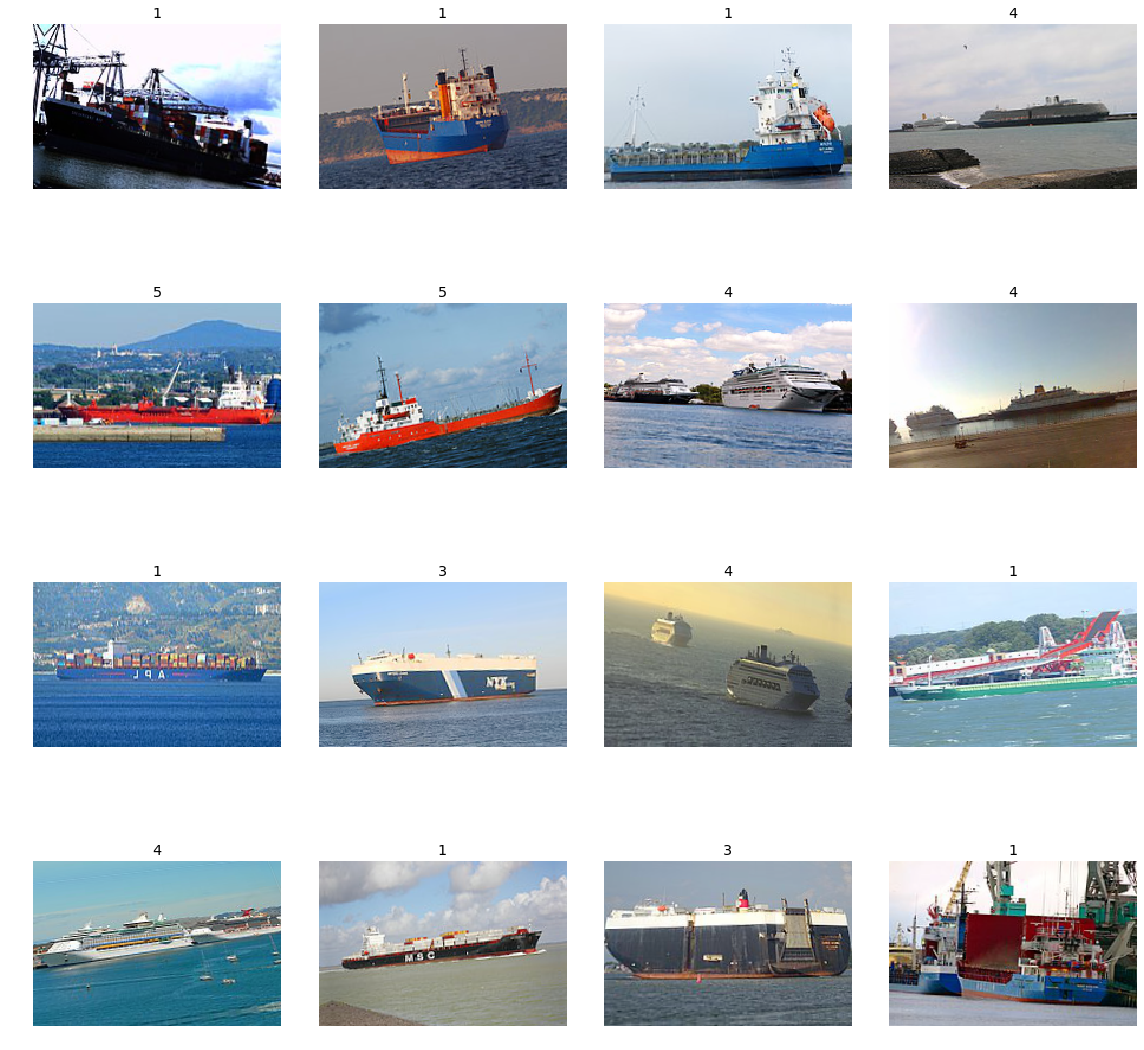

In [35]:
databunch.show_batch(rows=4)

In [17]:
train_labels = Counter(databunch.train_ds.y).most_common()
pd.DataFrame(train_labels, columns=['Class', 'Observations'])

,Class,Observations
0,1,1791
1,5,1029
2,2,1000
3,3,786
4,4,709


In [18]:
valid_labels = Counter(databunch.valid_ds.y).most_common()
pd.DataFrame(valid_labels, columns=['Class', 'Observations'])

,Class,Observations
0,1,329
1,5,188
2,2,167
3,3,130
4,4,123


In [9]:
# Add the test images to the DataBunch
test_img = ImageList.from_df(test_df, path='/home/jupyter/analytics_vidhya',
                             folder='test')
databunch.add_test(test_img)

In [23]:
databunch.label_list

LabelLists;

Train: LabelList (5315 items)
x: ImageList
Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210)
y: CategoryList
1,1,2,3,2
Path: images;

Valid: LabelList (937 items)
x: ImageList
Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210)
y: CategoryList
1,5,4,1,1
Path: images;

Test: LabelList (2680 items)
x: ImageList
Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210),Image (3, 140, 210)
y: EmptyLabelList
,,,,
Path: images

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


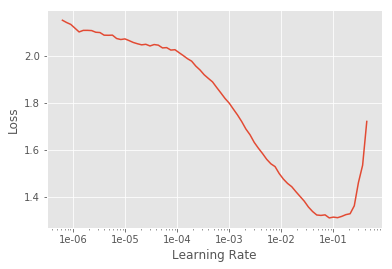

In [24]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy)
learner.lr_find();
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.723500,0.500560,0.807898,00:36
1,0.490987,0.344718,0.868730,00:35
2,0.363163,0.293540,0.892209,00:35
3,0.284644,0.265881,0.910352,00:35
4,0.234530,0.256518,0.910352,00:35


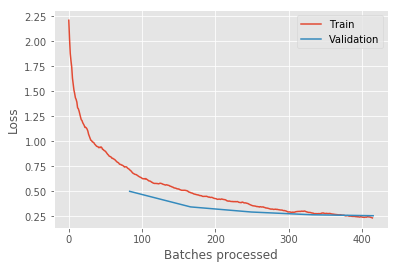

In [25]:
learner.fit_one_cycle(5, max_lr=slice(1e-04, 1e-02))
learner.recorder.plot_losses()

In [26]:
learner.save('stage-1-rn50')

In [27]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.228356,0.235672,0.915688,00:47
1,0.188207,0.222153,0.922092,00:46


In [28]:
learner.save('stage-2-rn50')

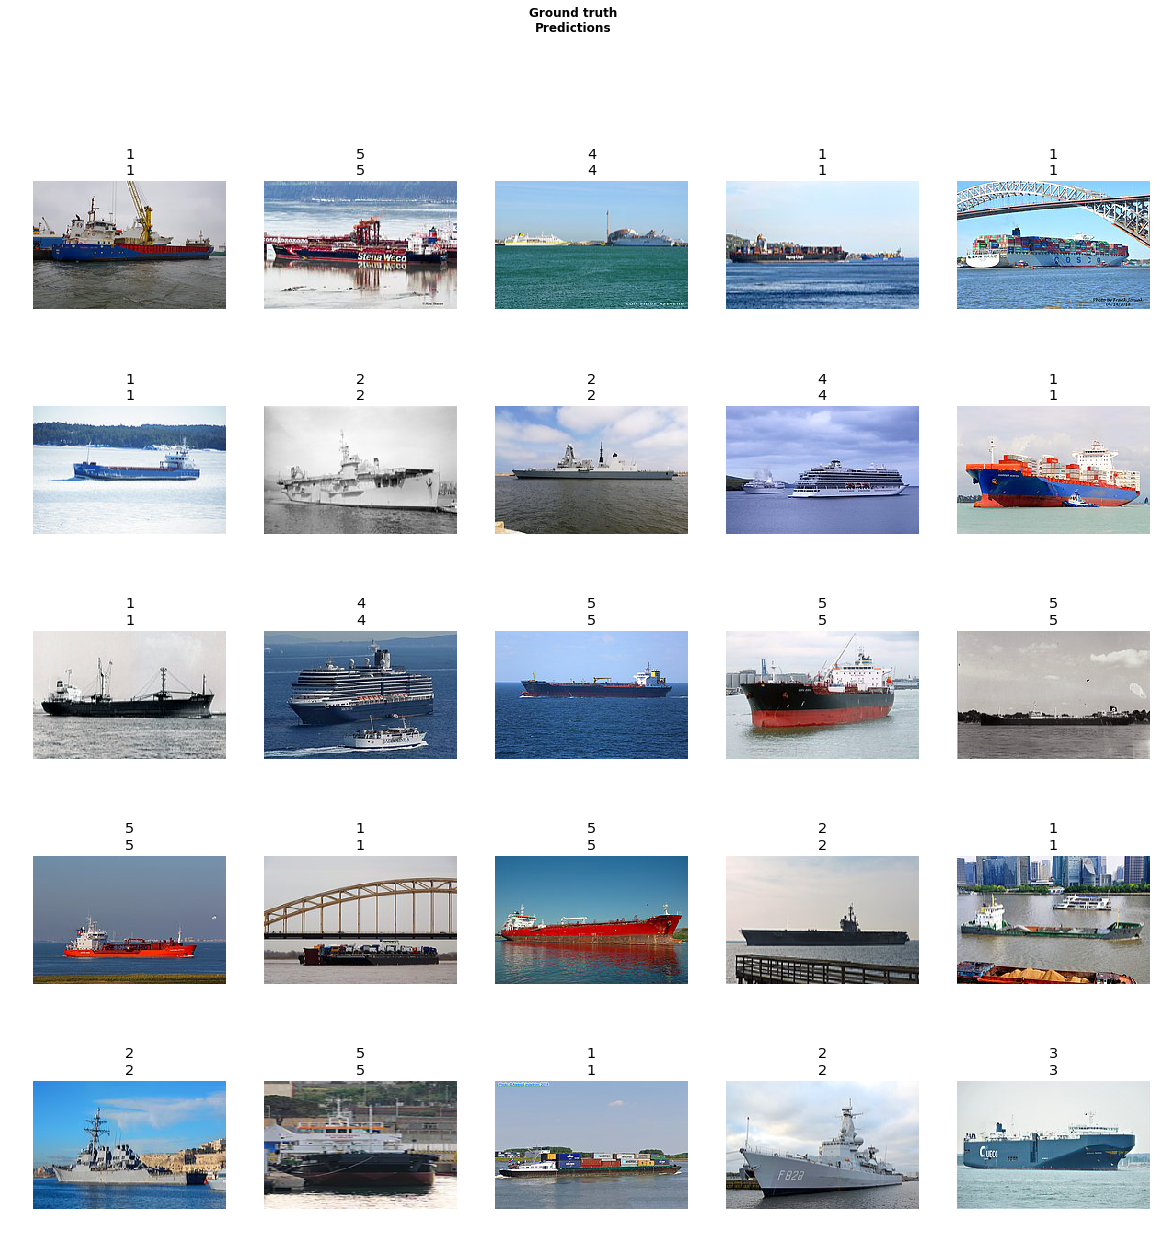

In [29]:
learner.show_results(ds_type=DatasetType.Valid)

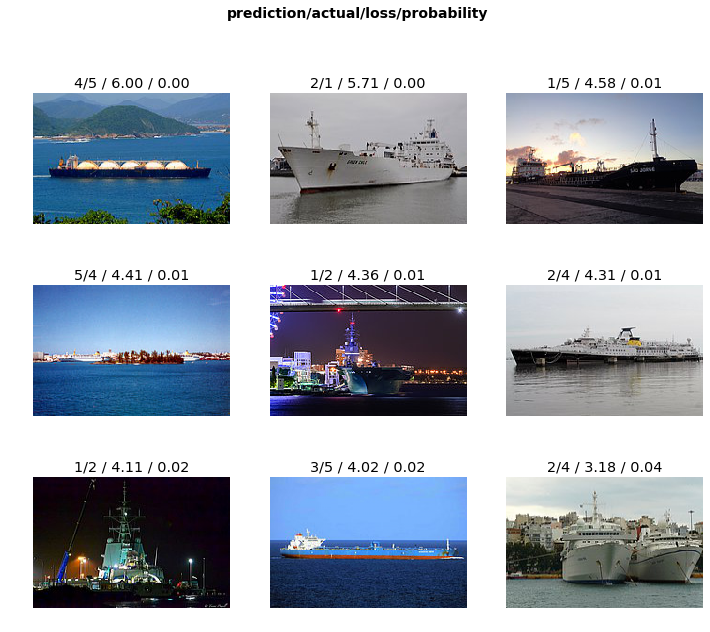

In [32]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

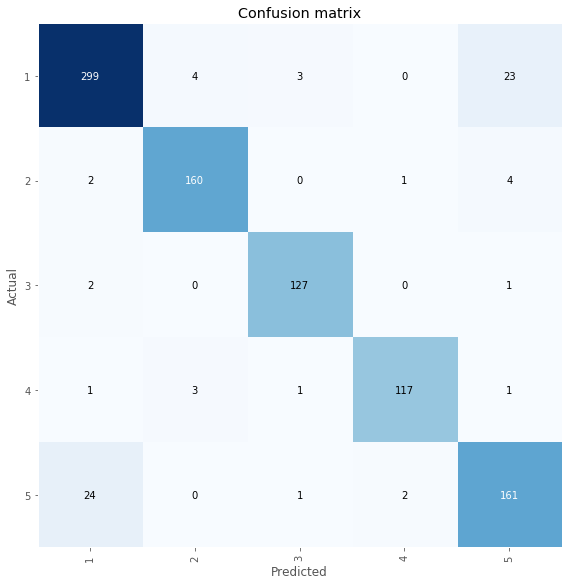

In [33]:
interp.plot_confusion_matrix(figsize=(8,8))

For reference:

```
{'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}
```

In [8]:
import time

def prepare_submission_file(learner):
    ts = time.time()
    pred_labels = []

    for i in range(len(learner.data.test_ds)):
        temp_pred = str(learner.predict(learner.data.test_ds[i][0])[0])
        pred_labels.append(temp_pred)
    submission = pd.read_csv('Submission.csv')
    submission['category'] = pred_labels

    file_name = 'submission_{}.csv'.format(ts)
    submission.to_csv('Submission_Files/'+file_name, index=False)
    return 'Submission file created successfully here {}'.format('Submission_Files/'+file_name)

epoch,train_loss,valid_loss,accuracy,time
0,0.206058,0.174710,0.927428,00:41
1,0.197406,0.162304,0.942369,00:35


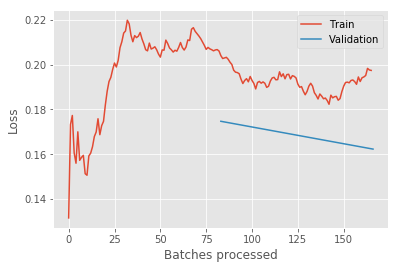

In [11]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy)
learner.load('stage-2-rn50')
learner.fit_one_cycle(2)
learner.recorder.plot_losses()

In [9]:
prepare_submission_file(learner)

'Submission file created successfully here Submission_Filessubmission_1559982970.5512779.csv'

In [13]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, path=Path('images'))

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learner, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, path=Path('images'), duplicates=True)

Getting activations...


Computing similarities...


In [5]:
databunch = ImageDataBunch.from_csv(Path('images'), ds_tfms=get_transforms(),
                                  csv_labels='cleaned.csv',
                                  valid_pct=0.,
                                size=(140,210), bs=64).normalize(imagenet_stats)

# Add the test images to the DataBunch
test_img = ImageList.from_df(test_df, path='/home/jupyter/analytics_vidhya',
                             folder='test')
databunch.add_test(test_img)

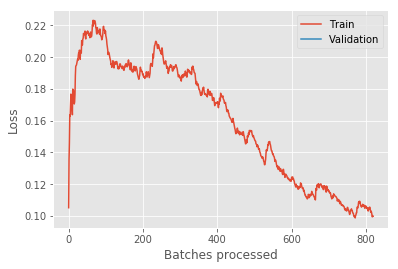

In [6]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy)
learner.load('stage-2-rn50')
learner.fit_one_cycle(10)
learner.recorder.plot_losses()

For reference:

```
{'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}
```

In [9]:
prepare_submission_file(learner)

'Submission file created successfully here Submission_Files/submission_1559987410.988816.csv'